In [2]:
# Refer to path of package
import sys
sys.path.append('/Users/watcharapongwongrattanasirikul/Documents/Git/Jupyter/my_env/lib/python3.8/site-packages')

In [3]:
# Import Lib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
import re
from random import choices, randint, randrange, uniform

In [4]:
from ml_helper import MlHelper
from eda_helper import EdaHelper
from sampling_helper import SamplingHelper
from impute_helper import ImputeHelper
from impute_helper import imputation_strategy
from ml_helper import model_type
from ml_helper import resampler_type
from ml_helper import scaler_type
import cleansing_helper as CleansingHelper

In [5]:
file_path = '/Users/watcharapongwongrattanasirikul/Documents/Git/predictive-maintenance/train_timeseries.csv'

df = pd.read_csv(file_path)
df.head(2)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0


In [6]:
df.drop(['RNF'], axis=1, inplace=True)
df.head(2)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0


In [7]:
# Rename of columns
df = df.rename(columns={
    'Air temperature [K]':'AirTemp',
    'Process temperature [K]':'ProcessTemp',
    'Rotational speed [rpm]':'RotationalSpeed',
    'Torque [Nm]':'Torque',
    'Tool wear [min]': 'ToolWear',
    'Machine failure':'MF'
})
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0


In [8]:
convert_type = {'H':1, 'M':2, 'L':3}

def mapping_type(item):
    if item in convert_type.keys():
      return convert_type[item]
    else:
      return -1

In [9]:
# encode type to be number

df['Type'] = df['Type'].apply(mapping_type)

In [10]:
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,L47181,3,298.2,308.7,1408,46.3,3,0,0,0,0,0


### Feature Engineering

In [11]:
# The importance feature of power failure  is Power then we create the Power feature 
# Power(kW) = Torque (N.m) x Speed (rpm)

df['Power'] = df['Torque'] * df['RotationalSpeed']
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,66382.8
1,2,L47181,3,298.2,308.7,1408,46.3,3,0,0,0,0,0,65190.4


In [12]:
# The importance feature of heat dissipation failure  is temperature
df['AirDiff'] = df['ProcessTemp'] - df['AirTemp']
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,66382.8,10.5
1,2,L47181,3,298.2,308.7,1408,46.3,3,0,0,0,0,0,65190.4,10.5


In [13]:
df[(df['AirDiff'] <= 8.6) & (df['RotationalSpeed'] < 1380)]

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff
3236,3237,M18096,2,300.8,309.4,1342,62.4,113,1,0,1,0,0,83740.8,8.6
3760,3761,L50940,3,302.3,310.9,1377,46.8,166,1,0,1,0,0,64443.6,8.6
3787,3788,L50967,3,302.3,310.8,1377,47.3,22,1,0,1,0,0,65132.1,8.5
3793,3794,L50973,3,302.3,310.9,1379,49.3,34,1,0,1,0,0,67984.7,8.6
3806,3807,M18666,2,302.3,310.9,1360,44.0,67,1,0,1,0,0,59840.0,8.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,4834,L52013,3,303.4,311.9,1377,41.6,34,1,0,1,0,0,57283.2,8.5
4836,4837,L52016,3,303.3,311.8,1315,62.0,42,1,0,1,0,0,81530.0,8.5
4840,4841,L52020,3,303.4,311.9,1298,63.9,59,1,0,1,0,0,82942.2,8.5
4844,4845,M19704,2,303.4,311.8,1316,50.9,69,1,0,1,0,0,66984.4,8.4


### Function for check behavior

In [14]:
df_TWF_positive = df[df['TWF']==1]
df_TWF_negative = df[df['TWF']==0]

/Users/watcharapongwongrattanasirikul/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/watcharapongwongrattanasirikul/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

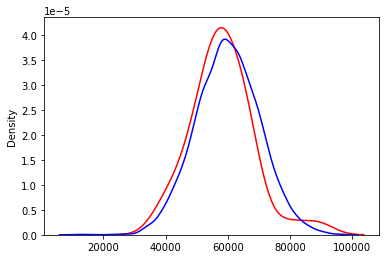

In [15]:
label = 'Power'

sns.distplot(x=df_TWF_positive[label],
                hist=False, 
                kde=True, 
                bins=int(100), 
                color = 'red',
                hist_kws={'edgecolor':'black'})

sns.distplot(x=df_TWF_negative[label],
                hist=False, 
                kde=True, 
                bins=int(100), 
                color = 'blue',
                hist_kws={'edgecolor':'black'})



In [16]:
def log_feature(val):
    result = np.log(val)
    
    if result not in [np.inf, -np.inf, np.NaN]:
        return result
    else:
        return 0

In [17]:
def devide_feature(val):
    if val[1] == 0:
        return 0
    else:
        return val[0]/val[1]

## Feature Importance

In [18]:
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,66382.8,10.5
1,2,L47181,3,298.2,308.7,1408,46.3,3,0,0,0,0,0,65190.4,10.5


In [19]:
# Check feature importance for PWF
df_feature_pwf = df.drop(['UDI', 'Product ID',  'MF', 'TWF', 'HDF', 'OSF'], axis=1)

importanc_feature_pwf = EdaHelper.get_feature_importance(df_feature_pwf, 'PWF')
importanc_feature_pwf

,score
Power,0.997879
Torque,0.002121


In [20]:
# Check feature importance for HDF
df_feature_hdf = df.drop(['UDI', 'Product ID', 'MF', 'TWF', 'PWF', 'OSF'], axis=1)

importanc_feature_hdf = EdaHelper.get_feature_importance(df_feature_hdf, 'HDF')
importanc_feature_hdf

,score
RotationalSpeed,0.782423
AirDiff,0.176121
ToolWear,0.011907
Type,0.009014
AirTemp,0.006156
Torque,0.005456
ProcessTemp,0.005067
Power,0.003857


In [21]:
# Check feature importance for OSF
df_feature_osf = df.drop(['UDI', 'Product ID',  'MF', 'TWF', 'PWF', 'HDF'], axis=1)

importanc_feature_osf = EdaHelper.get_feature_importance(df_feature_osf, 'OSF')
importanc_feature_osf

,score
ToolWear,0.535912
Torque,0.251349
Power,0.090014
Type,0.072692
RotationalSpeed,0.022547
AirDiff,0.010605
ProcessTemp,0.009562
AirTemp,0.007318


In [22]:
# Check feature importance for TWF
df_feature_twf = df.drop(['UDI', 'Product ID', 'MF', 'OSF', 'PWF', 'HDF'], axis=1)

importanc_feature_twf = EdaHelper.get_feature_importance(df_feature_twf, 'TWF')
importanc_feature_twf

,score
ToolWear,0.210861
Power,0.152768
RotationalSpeed,0.143335
ProcessTemp,0.138410
AirTemp,0.118512
Torque,0.112899
AirDiff,0.080826
Type,0.042389


## Plot Feature

In [23]:
def get_moving_average(df, window_size=10):
    windows = df.rolling(window_size)
    moving_average = windows.mean()
    moving_averages_list = moving_average.tolist()
    final_list = moving_averages_list[window_size - 1:]
    
    return(final_list)

In [30]:
def plot_feature_class(df, feautures, label, window_size=10):
    fig, ax = plt.subplots(len(feautures)+1, 1, figsize=(42,15))
    sns.lineplot(ax=ax[0], x=range(df.shape[0]), y=label, data=df, alpha=0.5, color='red' )
    
    
    for idx, feature in enumerate(feautures):
        sns.lineplot(ax=ax[idx+1], x=range(df.shape[0]), y=feautures[idx], data=df, alpha=0.5 )
        #sns.lineplot(ax=ax[idx+1], x=range(window_size-1, df.shape[0]), y=get_moving_average(df[feature], window_size), alpha=0.5 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() for i in range(df.shape[0])], alpha=0.2 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + df[feature].std() for i in range(df.shape[0])], alpha=0.2 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - df[feature].std() for i in range(df.shape[0])], alpha=0.2 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + (2 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - (2 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + (3 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - (3 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )

In [25]:
df.head(5)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,66382.8,10.5
1,2,L47181,3,298.2,308.7,1408,46.3,3,0,0,0,0,0,65190.4,10.5
2,3,L47182,3,298.1,308.5,1498,49.4,5,0,0,0,0,0,74001.2,10.4
3,4,L47183,3,298.2,308.6,1433,39.5,7,0,0,0,0,0,56603.5,10.4
4,5,L47184,3,298.2,308.7,1408,40.0,9,0,0,0,0,0,56320.0,10.5


In [26]:
df['AirDiff'].mean()

9.752524999999983

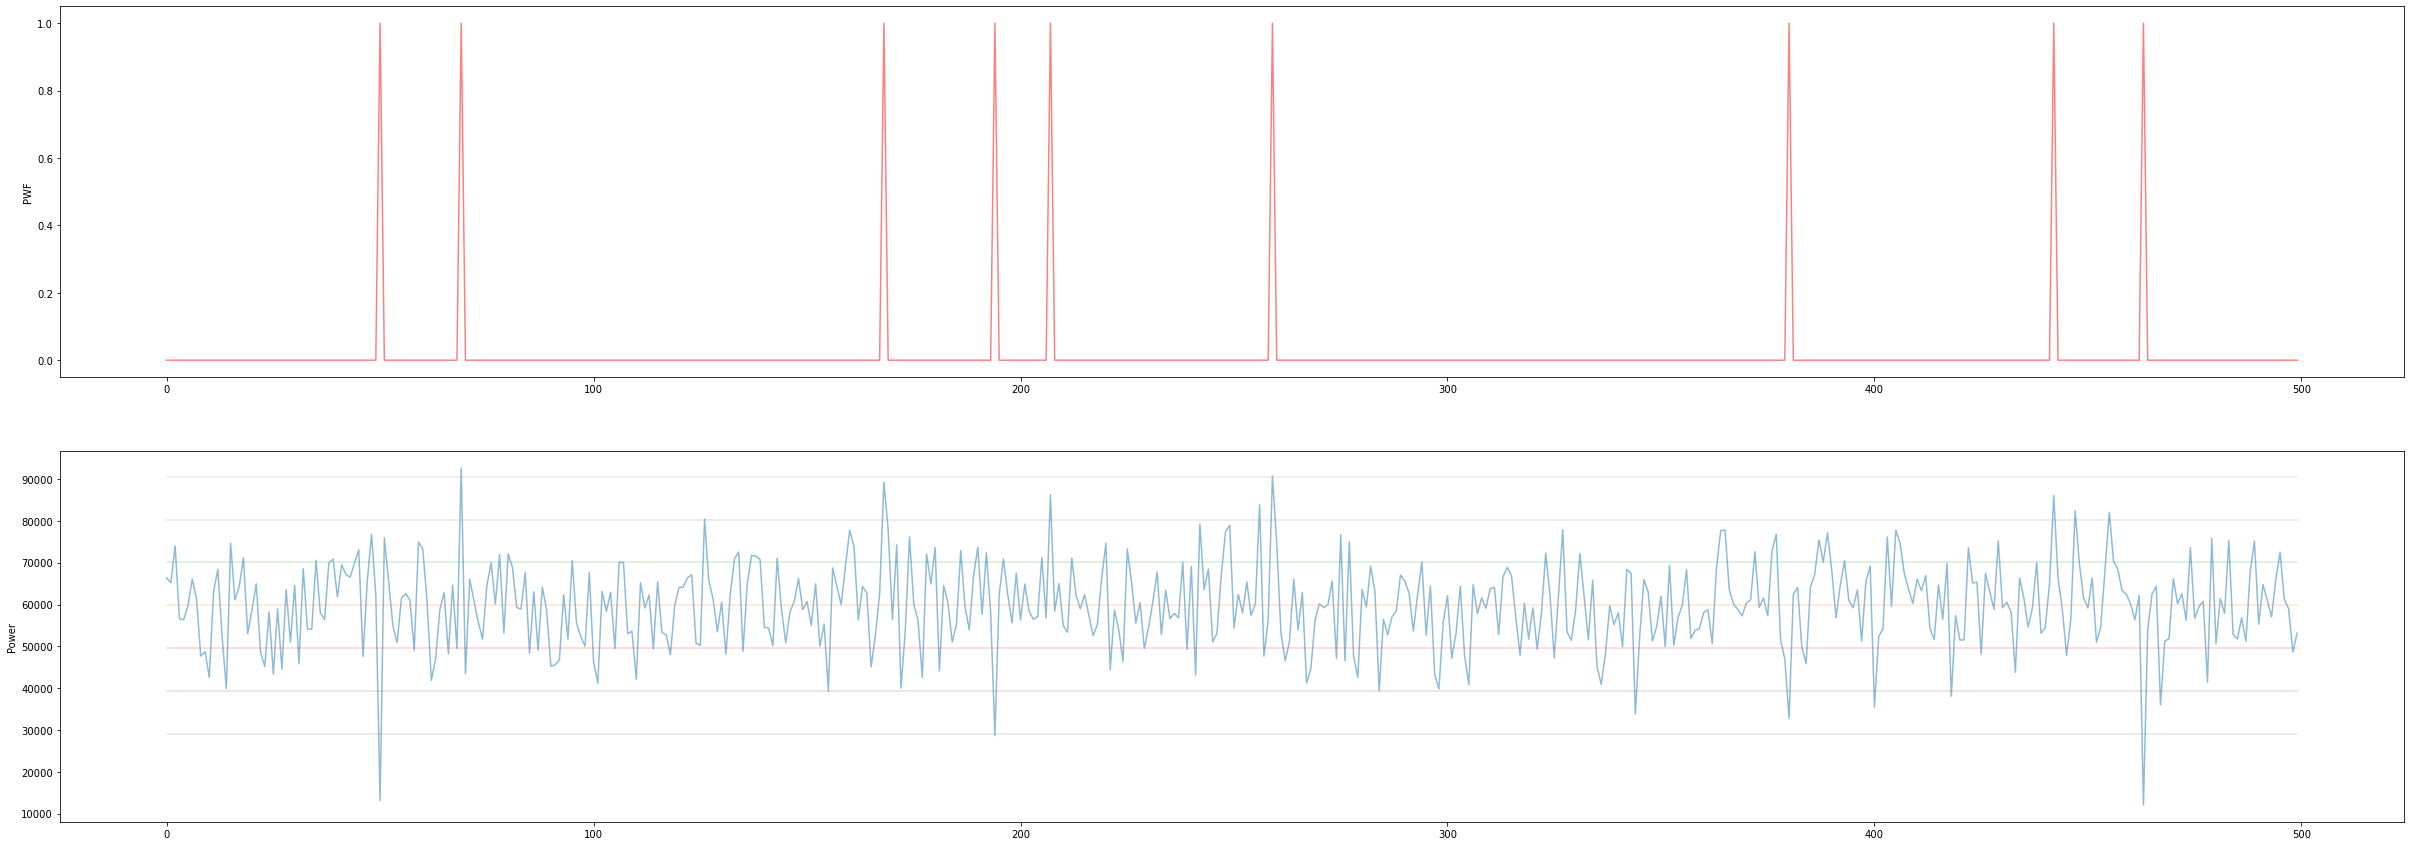

In [31]:
df_plot = df[0:500]
plot_feature_class(df_plot, ['Power'],'PWF')

In [28]:
encoded_torque[0:10]

NameError: name 'encoded_torque' is not defined

In [ ]:
def plot_class_distribution(df, label):
    c = ['Grey', 'Red']
    df.groupby('MF').size().plot(kind="bar", color=c)
    plt.title('Class Distribution', fontsize=18)
    plt.yticks(np.arange(0, 12000, 2000))
    # plt.grid()

    for index, value in enumerate(df.groupby(label).size()):
        c_label = ''
        if index == 0:
            c_label = 'Black'
        else:
            c_label = 'Red'
        plt.text(index - 0.1, value + 1000, str(value), color=c_label, fontsize=14)

    sns.despine()

In [ ]:
plot_class_distribution(df, 'MF')

# Genetic Algorithms to find the prediction pattern

## encoder function

In [107]:
# This function use to encode data point to be class label
# a = data less than or equal percentile 25
# b = data less than or equal percentile 50
# c = data less than or equal percentile 75
# d = data greater than percentile 75

def encode_feature(df, is_print_info=False):
    
    mean = np.mean(df)
    std = np.std(df)
    
    if is_print_info:
        print(f'mean: {mean}')
        print(f'std: {std}')
        print(f'a: {mean - (3*std)}')
        print(f'b: {mean - (2*std)}')
        print(f'c: {mean - (1*std)}')
        print(f'd: {mean}')
        print(f'e: {mean + (1*std)}')
        print(f'f: {mean + (2*std)}')
        print(f'g: {mean + (3*std)}')
    
    encoder_list = []
    
    for data_point in df:
        
        if is_print_info:
            print(data_point)
        
        if data_point <= (mean - (3*std)):
            encoder_list.append('a')
            continue
        
        if data_point <= (mean - (2*std)):
            encoder_list.append('b')
            continue
            
        if data_point <= (mean - (1*std)):
            encoder_list.append('c')
            continue
            
        if data_point <= mean:
            encoder_list.append('d')
            continue
            
        if data_point <= (mean + (1*std)):
            encoder_list.append('e')
            continue
            
        if data_point <= (mean + (2*std)):
            encoder_list.append('f')
            continue       
                        
        encoder_list.append('g')

    return encoder_list

In [105]:
df_AirDiff = df['AirDiff']
np.std(df_AirDiff)

0.953618699677705

In [ ]:
test_encoder = encode_feature(df_AirDiff, True)
test_encoder[100:110]

### Generate the random genome by specific length

In [32]:
def generate_genome(genome_length:int, num_pattern=1, num_feature=1):
    
    previous_gene = ''
    or_logic = False
    count_or = 0
    genome_feature = []
    
    for k in range(num_feature):
            
        genome_group = []
        
        for j in range(num_pattern):

            genome = []
            for i in range(genome_length):

                # First character should not be symbol
                if i == 0:
                    next_gene = choices(['a','b','c','d','e','f','g'], k=1)
                    genome = genome + next_gene
                    previous_gene = next_gene
                    continue

                # Last character should not be symbol
                if i == (genome_length-1):
                    next_gene = choices(['a','b','c','d','e','f','g'], k=1)
                    genome = genome + next_gene
                    previous_gene = next_gene
                    continue

                # If previous character is symbol then next character should not be symbol
                if previous_gene[0] == '.*' or previous_gene[0] == '|':
                    next_gene = choices(['a','b','c','d','e','f','g'], k=1)
                    genome = genome + next_gene

                    if previous_gene[0] == '|':
                        or_logic = True
                        count_or = 2

                    previous_gene = next_gene
                    continue

                if count_or > 0:
                    next_gene = choices(['a','b','c','d','e','f','g'], k=1)
                    genome = genome + next_gene
                    previous_gene = next_gene
                    count_or = count_or - 1
                    continue

                next_gene = choices(['a','b','c','d','e','f','g','.*','|'], k=1)            
                genome = genome + next_gene
                previous_gene = next_gene
            genome_group.append(genome)
        genome_feature.append(genome_group)
    
    return genome_feature

In [33]:
test_genome = generate_genome(genome_length=2, num_pattern=3, num_feature=4)
test_genome

[[['b', 'd'], ['b', 'c'], ['b', 'b']],
 [['c', 'd'], ['g', 'a'], ['f', 'a']],
 [['f', 'e'], ['e', 'c'], ['c', 'e']],
 [['e', 'b'], ['c', 'c'], ['a', 'f']]]

In [34]:
genome = test_genome[0]
len(test_genome)

4

In [35]:
for idx, genome in enumerate(test_genome):
    globals() [f'feature_{idx}'] = genome

In [36]:
feature_0

[['b', 'd'], ['b', 'c'], ['b', 'b']]

### Generate the population

In [37]:
def generate_population(size, genome_lenght, num_pattern=1, num_feature=1):
    return [generate_genome(genome_lenght, num_pattern, num_feature) for _ in range(size)]

In [38]:
test_population = generate_population(size=10, genome_lenght=2, num_pattern=3, num_feature=2)
for genome in test_population:
    print(genome)

[[['f', 'f'], ['g', 'b'], ['b', 'e']], [['d', 'b'], ['e', 'f'], ['b', 'd']]]
[[['f', 'g'], ['g', 'g'], ['g', 'c']], [['b', 'e'], ['b', 'g'], ['e', 'c']]]
[[['a', 'g'], ['d', 'f'], ['b', 'd']], [['f', 'a'], ['d', 'd'], ['c', 'b']]]
[[['f', 'f'], ['e', 'd'], ['a', 'c']], [['g', 'g'], ['g', 'c'], ['f', 'a']]]
[[['a', 'g'], ['b', 'd'], ['f', 'b']], [['g', 'f'], ['g', 'g'], ['c', 'e']]]
[[['b', 'd'], ['c', 'd'], ['b', 'b']], [['d', 'g'], ['b', 'c'], ['f', 'd']]]
[[['f', 'f'], ['e', 'f'], ['a', 'g']], [['f', 'b'], ['a', 'f'], ['b', 'c']]]
[[['a', 'b'], ['b', 'f'], ['c', 'b']], [['c', 'd'], ['d', 'c'], ['f', 'b']]]
[[['a', 'a'], ['a', 'c'], ['f', 'f']], [['f', 'b'], ['e', 'a'], ['g', 'a']]]
[[['f', 'e'], ['b', 'g'], ['c', 'e']], [['e', 'a'], ['b', 'd'], ['f', 'f']]]


### Get expression

In [39]:
def get_expression(data, num_pattern):
    
    
    or_flag = False
    expression_group = []
    
    for j in range(num_pattern):
        reg_result = ""
        
        for idx, i in enumerate(data[j]):

            if i == '|' and reg_result == "":
                raise Exception(f"The symbol '|' can't be the first parameter: {data}")

            if i == '|' and (idx + 1) == len(data[j]):
                raise Exception(f"The symbol '|' can't be the last parameter: {data}")

            if i in ('a', 'b', 'c', 'd','e','f','g','.*') and or_flag == False:
                reg_result = reg_result + i
                buf = i
                continue

            if i in ('a', 'b', 'c', 'd','e','f','g','.*') and or_flag == True:
                reg_result = reg_result + f"{i}]"
                or_flag = False
                continue

            if or_flag == True and (i == '|' or i == '.*'):
                reg_result = reg_result + 'd'
                continue

            if i == '|':
                reg_result = reg_result[0:(len(reg_result)- len(buf))]
                reg_result = reg_result + f"[{buf}|"
                or_flag = True
                continue
                
        expression_group.append('.*'+reg_result+".*")
 
    return expression_group

In [40]:
test_genome[0]

[['b', 'd'], ['b', 'c'], ['b', 'b']]

In [41]:
test_expression = get_expression(test_genome[0], num_pattern=3)

print(test_expression)

['.*bd.*', '.*bc.*', '.*bb.*']


### Encoded feature fortesting

In [42]:
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff
0,1,M14860,-1,298.1,308.6,1551,42.8,0,0,0,0,0,0,66382.8,10.5
1,2,L47181,-1,298.2,308.7,1408,46.3,3,0,0,0,0,0,65190.4,10.5


In [43]:
df_MF = df['MF']
df_TWF = df['TWF']
df_HDF = df['HDF']
df_PWF = df['PWF']
df_OSF = df['OSF']

df_torque = df['Torque']
df_speed = df['RotationalSpeed']
df_airtemp = df['AirTemp']
df_processtemp = df['ProcessTemp']
df_toolwear = df['ToolWear']
df_power = df['Power']
df_airdiff = df['AirDiff']

encoded_torque = encode_feature(df_torque)
encoded_speed = encode_feature(df_speed)
encoded_airtemp = encode_feature(df_airtemp)
encoded_processtemp = encode_feature(df_processtemp)
encoded_toolwear = encode_feature(df_toolwear)
encoded_power = encode_feature(df_power)
encoded_airdiff = encode_feature(df_airdiff)

In [42]:
test_genome = generate_genome(genome_length=3, num_pattern=2, num_feature=2)

In [43]:
test_genome

[[['d', 'b', 'g'], ['g', 'e', 'e']], [['b', 'b', 'f'], ['c', '.*', 'g']]]

In [45]:
def fitness_v2(genomes, encoded_features, df_state, window_size=20, num_pattern=1, is_print_message=False):
    
    is_print_message = is_print_message
    start = 0
    end = window_size
    
    fitness_score = 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    if len(genomes) != len(encoded_features):
        raise ValueError(f'Number of feature in genome ({len(genomes)}) should equal with number of feature in the encoded_feature ({len(encoded_features)})')
        
    number_round = int(len(encoded_features[0])/window_size)-1
    
    
    if is_print_message:
        print(f'Number of round: {number_round}')
        
    for i in range(number_round):
    
        predict_fail = True

        for idx, feature in enumerate(encoded_features):

            # Get current encoder feature
            current_pattern = ''.join(feature[start:end])

            # Get all predict patterns for feature i
            reg_expressions = get_expression(genomes[idx], num_pattern=num_pattern)

            if is_print_message:
                print(f'The current pattern: {current_pattern}')

            pattern_match = False
            for idx, reg_expression in enumerate(reg_expressions):

                matched = re.search(reg_expression, current_pattern)

                if is_print_message:
                    print(f'check_pattern {idx}: {reg_expression}')
                    print(f'feature is match: {matched}')

                if matched is not None and pattern_match == False:
                    pattern_match = True

            # At least 1 pattern from each predict feature match with own feature will predict next window has failed
            predict_fail = predict_fail and pattern_match
 

        if is_print_message:
            print(f'predict fail in next window: {predict_fail}')

        # Find the next period will have the fail case or not
        fail_next_period = list(df_state[end:end+window_size])

        is_fail_next_period = sum(fail_next_period)>0

        # Calculate Fitness Score
        if  predict_fail == True and is_fail_next_period == True:
            TP += 1

        if predict_fail == True and is_fail_next_period == False:
            FP += 1

        if predict_fail == False and is_fail_next_period == False:
            TN += 1

        if predict_fail == False and is_fail_next_period == True:
            FN += 1

        start += window_size
        end += window_size

    # Calculate accuracy
    if (TN + FP + TP + FN) == 0:
        accuracy = 0
    else:
        accuracy = (TN + TP)/(TN + FP + TP + FN)
        
    # Calculate recall    
    if (TP+FN) == 0:
        recall = 0
    else:
        recall = TP/(TP + FN)
    
    # Calculate precision
    if (TP+FP) == 0:
        precision = 0
    else:
        precision = TP/(TP+FP)
    
    # Calculate f1 score
    if (precision+recall) == 0:
        f1_score = 0
    else:
        f1_score = 2 * ((precision * recall)/(precision+recall))
        
    return(f1_score, accuracy, precision, recall)

In [45]:
test_genome = [[['a', 'a'], ['c','c']], [['b', 'c'], ['a','c']]]

In [46]:
a = ['a', 'a', 'b', 'c', 'd', 'a', 'a', 'b', 'c', 'd', 'a', 'a', 'b', 'c', 'd']
b = ['b', 'b', 'a', 'c', 'd', 'b', 'b', 'a', 'c', 'd', 'b', 'b', 'a', 'c', 'd']

fitness_v2(test_genome, encoded_features=[a, b], num_pattern=2, window_size=5, df_state=[0, 0, 0 ,0, 0,0, 0, 0 ,0, 0,0, 0, 0 ,0, 0,0, 0, 0 ,0, 0,0, 0, 0 ,0, 0,0, 0, 0 ,0, 0,0, 0, 0 ,0, 0,0, 0, 0 ,0, 0,0, 0, 0 ,0, 0,0, 0, 0 ,0, 0])

(0, 0.0, 0.0, 0)

### Calculate the fitness score

In [47]:
def fitness(genomes, encoder_results, df_state, window_size=20, is_print_counting = False, num_group=2):
    
    # Initial setting for window
    start = 0
    end = window_size
    number_round = int(len(encoder_results[0])/window_size)-1
    
    fitness_score = 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    # Parameter for counting
    count_predict_true = 0
    count_predict_false = 0
    count_not_match = 0
    
    # Get reg function from genome
    reg_expressions = get_expression(genome, num_group)
    
    predict_list = []
    
    # Iterate over the data by specific period
    for i in range(0, number_round):
        
        # Start by pattern doesn't matched
        predict_fail = False 
        
        # Get current pattern of feature
        for encoder_result in encoder_results:
            if predict_fail == True:
                continue
        
            current_pattern = ''.join(encoder_result[start:end])
        
            for reg_expression in reg_expressions:
                if predict_fail == True:
                    continue

                matched = re.search(reg_expression, current_pattern)

                if matched is not None:
                    predict_fail = True
                else:
                    predict_fail = False
        

        
        # Find the next period will have the fail case or not
        fail_next_period = list(df_state[end:end+window_size])
        is_fail_next_period = sum(fail_next_period)>0
    
        # Calculate Fitness Score
        if  predict_fail == True and is_fail_next_period == True:
            TP += 1
            
        if predict_fail == True and is_fail_next_period == False:
            FP += 1
            
        if predict_fail == False and is_fail_next_period == False:
            TN += 1
            
        if predict_fail == False and is_fail_next_period == True:
            FN += 1

        start += window_size
        end += window_size
        
    # Calculate accuracy
    if (TN + FP + TP + FN) == 0:
        accuracy = 0
    else:
        accuracy = (TN + TP)/(TN + FP + TP + FN)
        
    # Calculate recall    
    if (TP+FN) == 0:
        recall = 0
    else:
        recall = TP/(TP + FN)
    
    # Calculate precision
    if (TP+FP) == 0:
        precision = 0
    else:
        precision = TP/(TP+FP)
    
    # Calculate f1 score
    if (precision+recall) == 0:
        f1_score = 0
    else:
        f1_score = 2 * ((precision * recall)/(precision+recall))
    
    if is_print_counting == True:
        print(f'Count True: {count_predict_true}, False: {count_predict_false}, Not match: {count_not_match}')
    
    return(f1_score, accuracy, precision, recall)

In [48]:
encoder_results = [encoded_power]

In [51]:
test_genome = generate_genome(genome_length=5, num_pattern=2)

f1_score, accuracy, precision, recall = fitness(test_genome, encoder_results, df_MF, 40)
print(f1_score)

0.7902735562310031


### Selection Pair

In [46]:
def selection_pair(population, weights, number=10):
    return choices(
        population=population,
        weights= weights,
        k=number
    )

In [53]:
test_population

[[[['g', 'c'], ['d', 'b'], ['f', 'a']], [['a', 'f'], ['d', 'd'], ['f', 'c']]],
 [[['b', 'd'], ['d', 'e'], ['g', 'd']], [['c', 'b'], ['a', 'e'], ['d', 'f']]],
 [[['e', 'd'], ['f', 'g'], ['b', 'a']], [['e', 'b'], ['e', 'a'], ['f', 'g']]],
 [[['c', 'c'], ['e', 'e'], ['d', 'g']], [['g', 'c'], ['a', 'e'], ['f', 'a']]],
 [[['b', 'c'], ['b', 'd'], ['b', 'c']], [['d', 'g'], ['a', 'd'], ['b', 'b']]],
 [[['c', 'd'], ['c', 'e'], ['g', 'c']], [['g', 'f'], ['f', 'e'], ['g', 'c']]],
 [[['f', 'f'], ['b', 'g'], ['b', 'c']], [['c', 'a'], ['f', 'e'], ['c', 'g']]],
 [[['c', 'g'], ['g', 'f'], ['d', 'c']], [['d', 'g'], ['a', 'e'], ['a', 'd']]],
 [[['e', 'd'], ['f', 'c'], ['f', 'b']], [['a', 'a'], ['f', 'f'], ['b', 'g']]],
 [[['c', 'f'], ['a', 'c'], ['f', 'e']], [['b', 'g'], ['c', 'a'], ['f', 'b']]]]

In [54]:
weights = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
selected_genome = selection_pair(test_population, weights, number=2)
selected_genome

[[[['g', 'c'], ['d', 'b'], ['f', 'a']], [['a', 'f'], ['d', 'd'], ['f', 'c']]],
 [[['g', 'c'], ['d', 'b'], ['f', 'a']], [['a', 'f'], ['d', 'd'], ['f', 'c']]]]

### Cross Over

In [47]:
def single_point_cross_over(genome1, genome2, num_group=2):
    
    genome_result1 = []
    genome_result2 = []

    
    for i in range(num_group):
        if len(genome1[i]) != len(genome2[i]):
            print(genome1[i])
            print(genome2[i])
            raise ValueError("Genomes 1 and 2 must be of same length")

        length = len(genome1[i])

        if length < 2:
            offspring1 = genome1[i]
            offspring2 = genome2[i]

        if length >= 2:    
            position = randint(1, length-1)
            offspring1 = genome1[i][0:position] + genome2[i][position:]
            offspring2 = genome2[i][0:position] + genome1[i][position:]
        
        genome_result1.append(offspring1)
        genome_result2.append(offspring2)
        
    return genome_result1, genome_result2

In [56]:
test_genome1 = [[1, 2, 3, 4 ,5], [6, 7, 8, 9, 10], [11,12,13,14,15]]
test_genome2 = [[15,14,13,12,11],[10, 9 , 8, 7, 6], [5, 4, 3, 2, 1]]

print(single_point_cross_over(test_genome1, test_genome2, num_group=3))

([[1, 14, 13, 12, 11], [6, 7, 8, 9, 6], [11, 12, 3, 2, 1]], [[15, 2, 3, 4, 5], [10, 9, 8, 7, 10], [5, 4, 13, 14, 15]])


In [48]:
def single_point_cross_over_v2(genome1, genome2, num_pattern=2, num_feature=2):
    
    genome_cross1 = []
    genome_cross2 = []
    
    for idx in range(num_feature):
        
        genome_result1 = []
        genome_result2 = []
        
        buf_genome1 = genome1[idx]
        buf_genome2 = genome2[idx]
        
        for i in range(num_pattern):
            length = len(buf_genome1[i])
            
            if length < 2:
                offspring1 = buf_genome1[i]
                offspring2 = buf_genome2[i]
                
            if length >= 2:
                position = randint(1, length-1)
                offspring1 = buf_genome1[i][0:position] + buf_genome2[i][position:]
                offspring2 = buf_genome2[i][0:position] + buf_genome1[i][position:]
                
            genome_result1.append(offspring1)
            genome_result2.append(offspring2)
            
        genome_cross1.append(genome_result1)
        genome_cross2.append(genome_result2)
        
        
    return genome_cross1, genome_cross2

In [58]:
test_genome_1 = [[[1,2,3],[4,5,6]], [[7,8, 9],[10, 11,12]]]
test_genome_2 = [[[12,11, 10],[9, 8, 7]], [[6,5, 4],[3, 2, 1]]]

In [59]:
test1, test2 = single_point_cross_over_v2(test_genome_1, test_genome_2)

In [60]:
print(test1)
print(test2)

[[[1, 11, 10], [4, 5, 7]], [[7, 8, 4], [10, 2, 1]]]
[[[12, 2, 3], [9, 8, 6]], [[6, 5, 9], [3, 11, 12]]]


### Mutation

In [49]:
def mutation(genome, number=1, num_group=2):
    for i in range(num_group):
        for _ in range(number):
            index = randrange(len(genome[i]))
            genome[i][index] = choices(['a','b','c','d','e','f','g'], k=1)[0]

    return genome

In [62]:
test_genome3 = [[1, 2, 3, 4 ,5], [6, 7, 8, 9, 10]]
new = mutation(test_genome3)
new

[[1, 2, 3, 'c', 5], ['a', 7, 8, 9, 10]]

In [50]:
def mutation_v2(genome, number=1, num_pattern=2, num_feature=2):
    
    for idx in range(num_feature):
        for i in range(num_pattern):
            for _ in range(number):
                index = randrange(len(genome[i]))
                genome[idx][i][index] = choices(['a','b','c','d','e','f','g'], k=1)[0]

    return genome

In [64]:
test_genome_3 = [[[1,2,3],[4,5,6]], [[7,8, 9],[10, 11,12]]]

In [65]:
genome3_mutation = mutation_v2(test_genome_3, number=1, num_pattern=2, num_feature=2)
print(genome3_mutation)

[[[1, 'e', 3], ['f', 5, 6]], [[7, 'c', 9], ['e', 11, 12]]]


### Evolution

In [51]:
def run_evolution(encoded_feature, df_state,window_size, generation_limit=100, population_size=10, genome_length=10, num_group=2, print_log=False):
    
    print_step_info = False
    
    best_ever_max_score = 0
    best_ever_pattern = []
    
    # Parameter setting
    pop_crossover_threshold = 0.80
    pop_mutation_threshold = 0.02
    
    # --------------------------------------- 1. Generate Population --------------------------------------- #
    population = generate_population(size=population_size, genome_lenght=genome_length, num_group=num_group)
    
    if print_step_info:
        print(f'first population {population}')
    
    for i in range(generation_limit):
        
        # 1. Calculate fitness score for all population
        # f1_score:0, accuracy:1, precision:2, recall:3
        fitness_scores = [fitness(genome, encoded_feature, df_state=df_state, window_size=window_size, is_print_counting=False, num_group=num_group)[0] for genome in population]

        max_score = max(fitness_scores)
        
        if max_score > best_ever_max_score:
            best_ever_max_score = max_score
            
            population_and_score = list(zip(fitness_scores, population))
            population_and_score.sort(reverse=True)
            best_ever_pattern = population_and_score[0][1]
                
        if print_log:
            
            print(f'round {i} has max score {max_score}.')  #The whole score list {fitness_scores}')
            
        if print_step_info:   
            print('*'*50)
            population_and_score = list(zip(fitness_scores, population))
            print(f'population and score: {population_and_score}')
            print('*'*50)

        # 2. Evaluation
        if max_score >= 0.8:
            population_and_score = list(zip(fitness_scores, population))
            sorted_population_and_score = population_and_score.sort(reverse=True)
            top_population = sorted_population_and_score[0]
            print(f"The best population is {top_population[1]} with score {top_population[0]}")
            break

        # 3. Select new population
        if sum(fitness_scores) == 0:
            adjust_score = [1 for i in fitness_scores]
            
        else:
            adjust_score = [i for i in fitness_scores]
            weight_selection = [i/sum(adjust_score) for i in adjust_score] # Weight for random new population
            new_population = selection_pair(population, weight_selection, population_size)
            
            if print_step_info:   
                print('*'*50)
                print(f'new population: {new_population}')
                print('*'*50)

        # 4. Crossover
        offspring = []
        
        all_idx = list(range(len(new_population)))
        
        for idx, genome in enumerate(new_population):
            
            # Check index doesn't use yet
            if idx not in all_idx:
                continue
                
            # Remove the index of genome
            all_idx.remove(idx)
            
            # Get random index of other genome
            random_idx = choices(all_idx)[0]
            other_genome = new_population[random_idx]
            
            # Remove the index of other genome
            all_idx.remove(random_idx)
            
            # Check pop to cross over
            pop_crossover = uniform(0, 1)

            if pop_crossover <= pop_crossover_threshold:
                offspring1, offspring2 = single_point_cross_over(genome, other_genome, num_group=num_group)
            else:
                offspring1, offspring2 = genome, other_genome
                    
            offspring.append(offspring1)
            offspring.append(offspring2)

        new_population = offspring.copy()

        # 5. Mutation
        for idx, genome in enumerate(new_population):
            pop_mutation = uniform(0, 1)
            if pop_mutation <= pop_mutation_threshold: 
                new_population[idx] = mutation(genome, num_group=num_group)
        
        population = new_population
        
        # 6. Exist loop when exceed the generation_limit
        if i == generation_limit - 1:
            fitness_scores = [fitness(genome, encoded_feature, df_state=df_state, window_size=window_size, is_print_counting=False, num_group=num_group)[0] for genome in population]
            population_and_score = list(zip(fitness_scores, population))
            population_and_score.sort(reverse=True)
            top_population = population_and_score[0]
            
            f1_score, accuracy, precision, recall = fitness(top_population[1], encoded_feature, df_state=df_state, window_size=20, is_print_counting=False, num_group=num_group)
            #print(f"Last round the best population is {top_population[1]} with score {top_population[0]}")
            
    return(top_population, f1_score, accuracy, precision, recall, [best_ever_max_score, best_ever_pattern])
        

In [67]:
test_genome

[[['f', 'e', 'e', 'e', 'f'], ['c', 'a', '.*', 'd', 'd']]]

In [68]:
# Prepare encoded features
encoded_features = [enc]

# Prepare HDF state
df_HDF.head(2)

0    0
1    0
Name: HDF, dtype: int64

In [52]:
def run_evolution_2(population_size, genome_lenght, num_pattern, num_feature, encoded_features, df_state, window_size, generation_limit, is_print_info=False):
    
    # Parameter setting
    pop_crossover_threshold = 0.80
    pop_mutation_threshold = 0.02
    
    # --------------------------------------- 1. Generate Population --------------------------------------- #
    population = generate_population(size=population_size, genome_lenght=genome_lenght, num_pattern=num_pattern, num_feature=num_feature)
    
    for i in range(generation_limit):
    # --------------------------------------- 2. Calcureate Fitness Score ---------------------------------- #
        fitness_scores = [fitness_v2(genomes=genomes, encoded_features=encoded_features, df_state=df_state, window_size=window_size, num_pattern=num_pattern, is_print_message=True)[0] for genomes in population]
        
        if is_print_info:
            print(f'rount{i} has max score {max(fitness_scores)}')
        
    # --------------------------------------- 3. Select new population ------------------------------------- #
        if sum(fitness_scores) == 0:
            adjust_score = [1 for i in fitness_scores]
            weight_selection = [i/sum(adjust_score) for i in adjust_score] # Weight for random new population
            new_population = selection_pair(population, weight_selection, population_size)
        else:
            adjust_score = [i for i in fitness_scores]
            weight_selection = [i/sum(adjust_score) for i in adjust_score] # Weight for random new population
            new_population = selection_pair(population, weight_selection, population_size)
            
    # --------------------------------------- 4. Cross Over ------------------------------------- #
        offspring = []
        
        all_idx = list(range(len(new_population)))
        
        for idx, genome in enumerate(new_population):
            
            # Check index doesn't use yet
            if idx not in all_idx:
                continue
                
            # Remove the index of genome
            all_idx.remove(idx)
            
            # Get random index of other genome
            random_idx = choices(all_idx)[0]
            other_genome = new_population[random_idx]
            
            # Remove the index of other genome
            all_idx.remove(random_idx)
            
            # Check pop to cross over
            pop_crossover = uniform(0, 1)

            if pop_crossover <= pop_crossover_threshold:
                offspring1, offspring2 = single_point_cross_over_v2(genome, other_genome, num_pattern=num_pattern, num_feature=num_feature)
            else:
                offspring1, offspring2 = genome, other_genome
                    
            offspring.append(offspring1)
            offspring.append(offspring2)

        new_population = offspring.copy()
        
    # --------------------------------------- 5. Mutation ------------------------------------- #
#         for idx_mutation, genome in enumerate(new_population):
#             pop_mutation = uniform(0, 1)
#             if pop_mutation <= pop_mutation_threshold: 
#                 print(f'before {idx}: {new_population[idx]}')
#                 new_population[idx] = mutation_v2(genome, num_pattern=num_pattern, num_feature=num_feature)
#                 print(f'after: {new_population[idx]}')
                    
                
        

In [157]:
run_evolution_2(
    population_size=10,
    genome_lenght=5,
    num_pattern=3,
    num_feature=2,
    encoded_features=encoded_features,
    df_state=df_HDF,
    window_size=20,
    generation_limit=100,
    is_print_info=True
)

NameError: name 'encoded_features' is not defined

In [ ]:
encoded_features = [encoded_power]

In [ ]:
top_population, f1_score, accuracy, precision, recall, best_ever = run_evolution(
    encoded_feature=encoded_features,
    window_size=18,
    df_state=df_MF,
    generation_limit=2,
    population_size=10,
    genome_length=6,
    num_group=8,
    print_log=True)

### Test 1 Feature

In [75]:
test_features = [encoded_power]

top_population, f1_score, accuracy, precision, recall, best_ever = run_evolution(
    encoded_feature=test_features,
    window_size=20,
    df_state=df_PWF,
    generation_limit=10000,
    population_size=10,
    genome_length=6,
    num_group=2,
    print_log=True)

round 0 has max score 0.15.
round 1 has max score 0.22099447513812157.
round 2 has max score 0.22099447513812157.
round 3 has max score 0.22099447513812157.
round 4 has max score 0.22099447513812157.
round 5 has max score 0.304.
round 6 has max score 0.304.
round 7 has max score 0.30769230769230765.
round 8 has max score 0.30769230769230765.
round 9 has max score 0.30769230769230765.
round 10 has max score 0.30769230769230765.
round 11 has max score 0.30769230769230765.
round 12 has max score 0.30769230769230765.
round 13 has max score 0.30769230769230765.
round 14 has max score 0.30769230769230765.
round 15 has max score 0.30769230769230765.
round 16 has max score 0.30769230769230765.
round 17 has max score 0.30769230769230765.
round 18 has max score 0.30769230769230765.
round 19 has max score 0.30769230769230765.
round 20 has max score 0.30769230769230765.
round 21 has max score 0.304.
round 22 has max score 0.304.
round 23 has max score 0.304.
round 24 has max score 0.304.
round 25 

KeyboardInterrupt: 

### Generate Report

In [273]:
def generate_report(max_pattern_group, max_pattern_length, num_loop, window_sizes, df_state, encoded_feautes, print_log):
    df_report = pd.DataFrame(columns = ['window_size','num_group','pattern_length','Pattern','F1','Accuracy','Precision','Recall'])
                           
    # ! Wait for change 3 back to be parameter num_group
    for num_group in range(1,4):
        for genome_length in range(5,max_pattern_length+1):
            for window_size in window_sizes:
                
                if genome_length >= window_size:
                    continue
            
                top_population, f1_score, accuracy, precision, recall = run_evolution(
                    encoded_feature=encoded_feautes,
                    window_size=window_size,
                    df_state=df_state,
                    generation_limit=num_loop,
                    population_size=10,
                    genome_length=genome_length,
                    num_group=num_group,
                    print_log=print_log)
            
                data = [window_size,num_group,genome_length, top_population, f1_score, accuracy, precision, recall]

                try:
                    df_report.loc[len(df_report)] = data
                    print(f'complete for window_size {window_size} number_group {num_group} and genome_length {genome_length}.')
                except Exception as e:
                    print(f'error for window_size {window_size}  number_group {num_group} and genome_length {genome_length}.')
                    print('*'*50)
                    print(e)
                    print('*'*50)
                
    return df_report
                             
                             
    

In [274]:
test_features = [encoded_power]

result = generate_report(
    max_pattern_group=10,
    max_pattern_length=20,
    window_sizes= [5,  10,  15, 20],
    df_state=df_PWF,
    encoded_feautes=encoded_features,
    num_loop=5,
    print_log=False
)

complete for window_size 10 number_group 1 and genome_length 5.
complete for window_size 15 number_group 1 and genome_length 5.
complete for window_size 20 number_group 1 and genome_length 5.
complete for window_size 10 number_group 1 and genome_length 6.
complete for window_size 15 number_group 1 and genome_length 6.
complete for window_size 20 number_group 1 and genome_length 6.
complete for window_size 10 number_group 1 and genome_length 7.
complete for window_size 15 number_group 1 and genome_length 7.
complete for window_size 20 number_group 1 and genome_length 7.
complete for window_size 10 number_group 1 and genome_length 8.
complete for window_size 15 number_group 1 and genome_length 8.
complete for window_size 20 number_group 1 and genome_length 8.
complete for window_size 10 number_group 1 and genome_length 9.
complete for window_size 15 number_group 1 and genome_length 9.
complete for window_size 20 number_group 1 and genome_length 9.
complete for window_size 15 number_group

In [277]:
pd.set_option('display.max_rows', None)
result.sort_values(by=['F1'], ascending=False)

,window_size,num_group,pattern_length,Pattern,F1,Accuracy,Precision,Recall
35,20,2,6,"[[d, c, |, c, |, d], [e, d, c, d, e, f]]",0.323009,0.233083,0.193634,0.973333
2,20,1,5,"[[d, .*, c, |, c]]",0.318707,0.260652,0.192737,0.920000
64,15,3,6,"[[f, |, d, e, |, f], [a, d, .*, e, e, a], [f, ...",0.316456,0.187970,0.187970,1.000000
62,20,3,5,"[[f, |, d, .*, d], [e, d, f, |, d], [a, |, b, ...",0.316456,0.187970,0.187970,1.000000
65,20,3,6,"[[c, e, g, b, d, e], [c, |, c, .*, e, e], [d, ...",0.314199,0.431078,0.203125,0.693333
31,15,2,5,"[[d, c, d, |, e], [g, a, d, a, b]]",0.312757,0.581454,0.226190,0.506667
10,15,1,8,"[[d, .*, d, .*, d, d, .*, f]]",0.312000,0.568922,0.222857,0.520000
34,15,2,6,"[[e, .*, e, e, |, g], [a, f, a, |, e, f]]",0.298734,0.305764,0.184375,0.786667
5,20,1,6,"[[e, g, |, b, |, d]]",0.297593,0.195489,0.178010,0.906667
60,10,3,5,"[[g, .*, e, f, g], [f, a, c, g, f], [a, |, d, ...",0.286645,0.451128,0.189655,0.586667


In [278]:
file_path = '/Users/watcharapongwongrattanasirikul/Documents/Git/predictive-maintenance/result_PWF_(power)_1000.csv'
result.to_csv(file_path, index=None)

In [ ]:
.....bedc...... ---> Fail

In [ ]:
.....bedb......

In [ ]:
df_feature = df_scale['Tor-Rot']
feature_encoded = encode_feature(df_feature) 

In [ ]:
df_PWF = df['PWF']

In [ ]:
population = generate_population(10, 5)

score = run_evolution(population, encode_torque, df_PWF, 20000)

In [ ]:
a = ['A', 'B', 'C']
b = [3, 2, 1]

result = zip(b, a)
c =list(result)

In [ ]:
c

In [ ]:
c.sort(reverse=False)
c

In [ ]:
c[0][1]

In [ ]:
encode_torque

In [ ]:
for i in scores:
    print(type(i))

In [ ]:
weight = [i/sum(scores) for i in scores]
weight

In [ ]:
a1

In [ ]:
a2 = mutation(a1)

In [ ]:
a2

In [ ]:
a = generate_genome(10)
b = generate_genome(10)

In [ ]:
a1, b1 = single_point_cross_over(a, b)

In [ ]:
print(a)
print(b)
print(a1)
print(b1)

In [ ]:
fitness(test_genome, encode_torque, 'a')

In [ ]:
population_test = generate_population(10, 10)

In [ ]:
p = selection_pair(population_test, fitness)

In [263]:
randint(1, 10)

2

In [ ]:
a = generate_genome(10)
a

In [ ]:
get_expression(a)

In [ ]:
# Test rolling windows

test_list = [1,2,3,4,5,7,8,9,10]

windows = pd.DataFrame(test_list).rolling(2)

for idx, i in enumerate(windows):
    print(list(i[0]))

In [ ]:
a = [1,2,3,4]

In [ ]:
weight = [i/sum(a) for i in a]

In [ ]:
weight